Import libraries

In [1]:
import pandas as pd
import numpy as np # library to handle data in a vectorized manner
import random

import geopy
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import colors as mcolors
from scipy import stats

# import k-means from clustering stage
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.cluster import KMeans
import folium # map rendering library
from folium.plugins import HeatMap

print('Libraries imported.')


Libraries imported.


In [2]:
CLIENT_ID = 'X3INNHZFS0RE4YAMNP5CCG4UVUP4S5K1S4NZIIXKHN2UNXJW' # your Foursquare ID
CLIENT_SECRET = '20EOF0IP0MALLD0RO0MM1QOCLEHXC35L4U3JHMETTEF24YJR' # your Foursquare Secret

VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: X3INNHZFS0RE4YAMNP5CCG4UVUP4S5K1S4NZIIXKHN2UNXJW
CLIENT_SECRET:20EOF0IP0MALLD0RO0MM1QOCLEHXC35L4U3JHMETTEF24YJR


In [3]:

def get_colors(n):
    return list(map(lambda i: "#" + "%06x" % random.randint(0, 0xFFFFFF),range(n)))

In [4]:
def data_features_draw_hist(data,n_bins,nplots,nrows,ncols,Title):
            """Visualization of statistical distributions."""
            np.random.seed(19680801)
            nbins=25
            ntotal=nrows*ncols
            df=data
            dfs=df.describe()
            if nplots <= 7:
                colors = [ic for ic in mcolors.BASE_COLORS.values() if ic !=(1,1,1)]
            else: 
                colors=get_colors(nplots)
         
            columns=df.columns
            
            fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15,15))
            fig.set_canvas(plt.gcf().canvas)
            
         
            for ii,axt,color in zip(range(len(columns)),axs.flat[:nplots],colors):
                    data=df.iloc[:,ii]
                    count,mean,std,min,Q25,Q50,Q75,max=dfs.iloc[:,ii]
                    bins=np.linspace(min,max,100)
                    axt.hist(data.T, n_bins, density=True, histtype='bar', color=color,label='frequency')
                    axt.legend(prop={'size': 10})
                    bin_centers = 0.5*(bins[1:] + bins[:-1])
                    pdf = stats.norm.pdf(bin_centers,mean,std)
                    axt.plot(bin_centers,pdf,color=(0.3,0.5,0.2),lw=2)
            
                    axt.set_title(df.columns[ii])

            for axt in axs.flat[nplots:]:
                        axt.axis('off')

            plt.suptitle(Title)
            fig.tight_layout(rect=[0, 0.03, 1, 0.95])
            #fig.tight_layout()
            savefig=Title + '.png'
            return fig.savefig(savefig),plt.show()


In [5]:
#Create heatmap with properties
def heatmap(address,zoom_start,prop,ii):
    geolocator = Nominatim(user_agent="to_explorer",timeout=50)
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    prop_heat=prop[prop.columns[ii]].values.tolist()
    max_heat=float(prop[prop.columns[ii]].max())
    # create map
    map_heat= folium.Map(location=[latitude, longitude], zoom_start=zoom_start)
    # add markers to the map
    map_properties = HeatMap( list(zip(prop.Latitude.values, prop.Longitude.values, prop_heat)),
                   min_opacity=0.2,
                   max_val=max_heat,
                   radius=17, 
                   blur= 15, 
                   max_zoom=1, 
                 ).add_to(map_heat)
    
    return map_heat


In [6]:
def frame_from_list(y,xlabel,ylabel,Title,mapping,grid,text,Labels,boxstyle,xticks,yticks):
        """From dict with orient='index'"""
        """ y-list of p-matrix of n*2 order """
        X=[]
        Y=[]
        Z=[]
        for elem in y:
            Z.append(elem.index)
            if elem.shape[1] > 1:
                X.append(elem[elem.columns[0]].values)
                Y.append(elem[elem.columns[1]].values)
            else:
                X.append(elem.index)
                Y.append(elem[elem.columns[0]].values)
            
        maxX=max([r.max() for r in Z])+1
        X=pd.DataFrame(X,index=Labels,columns=range(0,maxX)).T
        Y=pd.DataFrame(Y,index=Labels,columns=range(0,maxX)).T
    
        if mapping=='Log':
            Title='Log20 '+Title
            Y=np.log(np.abs(Y))/np.log(20)
        
        Title=Title
        xlabel=xlabel
        ylabel=ylabel
        Linestyle=['-','-.','--',':','--','solid','dashed','dashdot','dotted'] 
        return plot_matrix_matrix(X,Y,Title,xlabel,ylabel,Labels,\
                                            Linestyle,0,mapping,grid,text,boxstyle,xticks,yticks)

In [7]:
def kmeans_clustering_evaluation(y,xlabel,ylabel,Title,mapping,grid,text,Labels,boxstyle,xticks,yticks):
        """From dict with orient='index'"""
        """ y-list of p-matrix of n*2 order """

        R=[]
        Z=[]
        S=[]
        P=[]
        for elem in y:
            Z.append(elem.index)
            R.append(elem[elem.columns[0]][:-2].values)
            # Silhouette coefficient
            S.append(elem.loc[elem.index[-2],elem.columns[0]])   
            P.append(elem.loc[elem.index[-1],elem.columns[0]]) 
        maxZ=max([r.max() for r in Z])-1
    
        # Compute entropy associated to clustering
        Y=pd.DataFrame(R,columns=range(0,maxZ)).T
        W=Y/Y.sum()
        W=W.fillna(1)
        Y=W.apply(lambda x:-sum(x*np.log(x)/np.log(2))) 
        P=pd.DataFrame(P, columns=['Purity'])
        S=pd.DataFrame(S,columns=['Silhouette coef'])
        Y=pd.DataFrame(Y, columns=['Entropy'])
        Y=pd.concat([Y,S,P],axis=1)
         
        # build X
        m,n=Y.shape
        X=np.array(np.ones((m,n)))
        X=np.array(X)
        X=pd.DataFrame(X)

        X.loc[0,:]=0
        X=np.cumsum(X)
        
        
        if mapping=='Log':
            Title='Log20 '+Title
            Y=np.log(np.abs(Y))/np.log(20)
        if mapping =='XLog':
            X=np.log(np.abs(X))/np.log(20)
            xlabel='Log20'+ xlabel
            
        Title=Title
        xlabel=xlabel
        ylabel=ylabel
        Linestyle=['-','-.','--',':','--','solid','dashed','dashdot','dotted'] 

        return plot_matrix_matrix(X,Y,Title,xlabel,ylabel,Labels,Linestyle,0,mapping,grid,text,boxstyle,xticks,yticks)
    

In [8]:
def plot_matrix_matrix(X,Y,Title,xlabel,ylabel,Labels,\
                           Linestyle,kind,scale,grid,text,boxstyle,xticks,yticks):
        """Draw matrix vs matrix."""
        """
        kind of graphic
        0-plot
        1-scatter
        2-stem
        scale of plot
        'equal'
        'Log'
        'semilogy'
        'semilogx'
        'Loglog'
        """
        import matplotlib.pyplot as plt
        from matplotlib import colors as mcolors
        # colors for grahics with matplolib and plotly
        
        colors = [ic for ic in mcolors.BASE_COLORS.values() if ic !=(1,1,1)]
        keys   = [kc  for kc in mcolors.BASE_COLORS.keys() if mcolors.BASE_COLORS[kc]!=(1,1,1)]

        """
        Checking orders of matrices
        """
        if (X.shape[0]!=Y.shape[0] or X.shape[1]!=Y.shape[1]):
                    print("These matrices are not equal order")
    
        Y.iloc[1,:] 
        idx=[X.iloc[:,i].argsort() for i in range(X.shape[1])]
        plt.figure()
        ax=plt.subplot(1,1,1)
        for i,linestyle in enumerate(Linestyle):
            if i in range(X.shape[1]):
                label=Labels[i]

                if kind==0 :
                    if scale=='equal' or 'Log':
                        ax.plot(X.iloc[idx[i],i],Y.iloc[idx[i],i],linestyle=linestyle,linewidth=1.5,label=label,color=colors[i])
                        if len(xticks) > 0:
                            ax.set_xticks(range(len(xticks)))
                            ax.set_xticklabels(xticks)
                            ax.xaxis.set_ticks_position('bottom')
                        if len(yticks) > 0: 
                            ax.set_yticks(range(len(yticks)))
                            ax.set_yticklabels(yticks)
                    elif scale=='semilogy':
                            ax.semilogy(X.iloc[idx[i],i],Y.iloc[idx[i],i],linestyle=linestyle,linewidth=1.5,label=label,color=colors[i])
                    elif scale =='semilogx':
                            ax.semilogx(X.iloc[idx[i],i],Y.iloc[idx[i],i],linestyle=linestyle,linewidth=1.5,label=label,color=colors[i])
                    elif scale =='Loglog':
                            ax.loglog(X.iloc[idx[i],i],Y.iloc[idx[i],i],linestyle=linestyle,linewidth=1.5,label=label,color=colors[i])
                    else:
                         pass
                elif kind==1:
                      ax.scatter(X.iloc[idx[i],i],Y.iloc[idx[i],i],marker=linestyle,label=label,color=colors[i])
                elif kind==2:
                    markerline, stemlines, baseline = ax.stem(X.iloc[idx[i],i],Y.iloc[idx[i],i],'-.',\
                                                             markerfmt=keys[i]+'o',label=label)
                   #ax.setp(baseline, color='r', linewidth=1.5)
                else:
                    pass
            else:
                pass

        ax.legend(prop={'size':10})
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.title(Title)
        plt.tight_layout(rect=[0, 0, 1, 1])
        plt.grid(grid)
        plt.grid(color=colors[0],linestyle='',linewidth='1')
        if len(text)>0:
              plt.text(0.1, 85.0,text,\
                     {'color': 'k', 'fontsize':10, 'ha': 'left', 'va': 'center',\
                      'bbox': dict(boxstyle=str(boxstyle), fc="w", ec="k", pad=0.3)})

        return plt.show()

In [9]:
boroughs=pd.read_csv("/home/sedna/Downloads/PROJECT-COURSERA-CAPSTONE/DATA/Boroughs_london.csv",index_col=0)

In [10]:
boroughs.head()

,Code,Borough,Inner/Outer,GLA_P2017,GLA_H2017,Latitude,Longitude
0,E09000001,City of London,Inner London,8800,5326,51.5155,-0.0922
1,E09000002,Barking and Dagenham,Outer London,209000,78188,51.5607,0.1557
2,E09000003,Barnet,Outer London,389600,151423,51.6252,-0.1517
3,E09000004,Bexley,Outer London,244300,97736,51.4549,0.1505
4,E09000005,Brent,Outer London,332100,121048,51.5588,-0.2817


In [11]:
boroughs_heat_map=pd.read_excel("/home/sedna/Downloads/PROJECT-COURSERA-CAPSTONE/RESULTS/heat_map_b05.xlsx", index_col=0)

In [12]:
boroughs_map=boroughs_heat_map[boroughs_heat_map.columns[1:]]


In [13]:
boroughs_sel=boroughs[boroughs.columns[3:]]

In [14]:
boroughs_heat=pd.concat([boroughs_sel,boroughs_map], axis=1)

In [15]:
boroughs_heat.rename(columns={'GLA_P2017':'GLA Population 2017', 'GLA_H2017':'GLA Household 2017' },inplace=True)

In [16]:
boroughs_heat.head()

,GLA Population 2017,GLA Household 2017,Latitude,Longitude,arts_entertainment,building,food,nightlife,parks_outdoors,shops,travel
0,8800,5326,51.5155,-0.0922,0,1,0,0,3,2,1
1,209000,78188,51.5607,0.1557,0,0,2,0,0,0,1
2,389600,151423,51.6252,-0.1517,1,1,11,3,1,10,1
3,244300,97736,51.4549,0.1505,3,1,31,6,3,18,9
4,332100,121048,51.5588,-0.2817,0,3,21,4,0,14,0


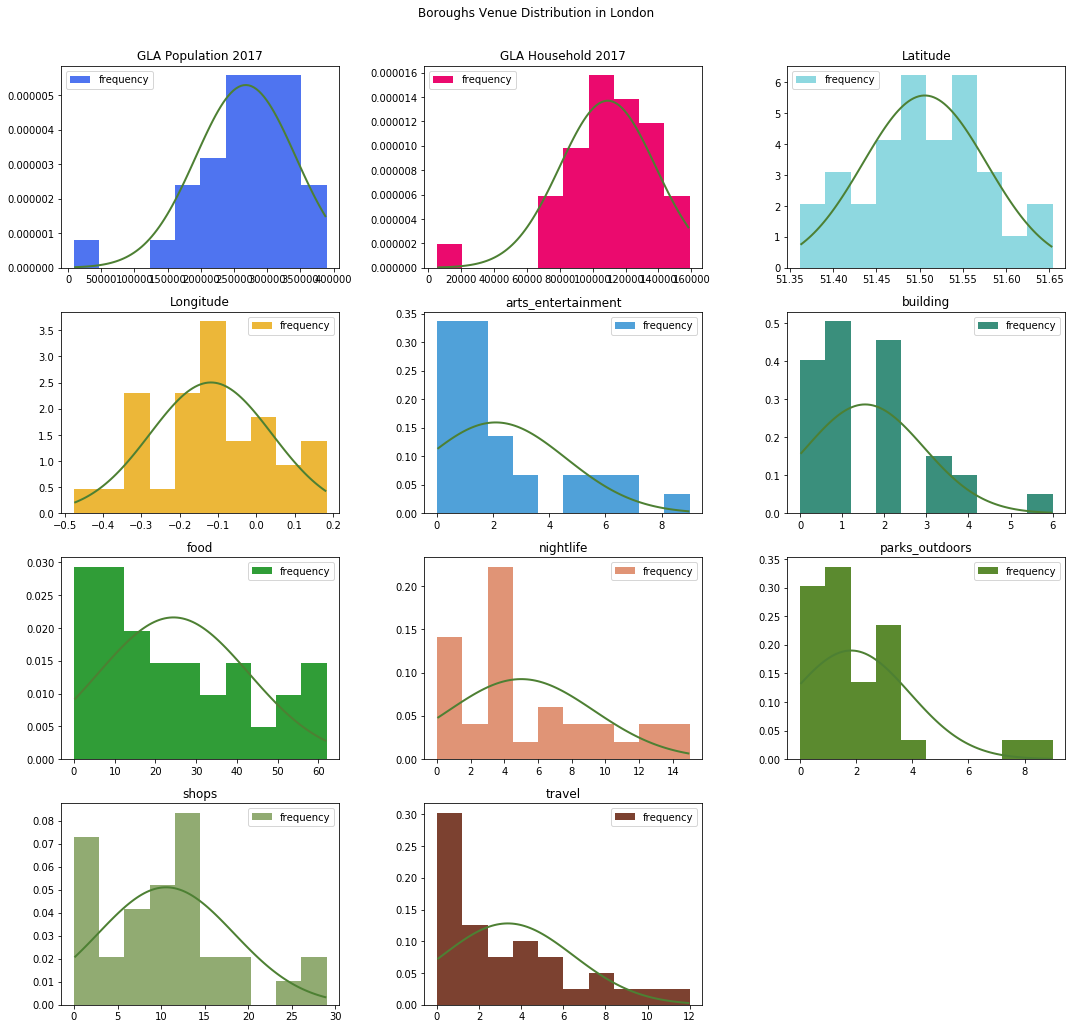

(None, None)

In [17]:
Title='Boroughs Venue Distribution in London'
data_features_draw_hist(boroughs_heat,10,11,4,3,Title)


In [18]:
address='London,UK'
zoom_start=11
prop=boroughs_heat
ii=0
heatmap(address,zoom_start,prop,ii)

In [19]:
ii=1
heatmap(address,zoom_start,prop,ii)

In [20]:
ii=2
heatmap(address,zoom_start,prop,ii)

In [21]:
ii=3
heatmap(address,zoom_start,prop,ii)

In [22]:
ii=4
heatmap(address,zoom_start,prop,ii)

In [23]:
ii=5
heatmap(address,zoom_start,prop,ii)

In [24]:
ii=6
heatmap(address,zoom_start,prop,ii)

In [25]:
ii=7
heatmap(address,zoom_start,prop,ii)

In [26]:
ii=8
heatmap(address,zoom_start,prop,ii)

In [27]:
ii=9
heatmap(address,zoom_start,prop,ii)

In [28]:
ii=10
heatmap(address,zoom_start,prop,ii)

Neighbourhoods

In [29]:
neighbourhoods=pd.read_csv('/home/sedna/Downloads/PROJECT-COURSERA-CAPSTONE/DATA/neighbourhoods_london.csv',index_col=0)

In [30]:
neighbourhoods.head()

,Borough,Neighbourhood,Latitude,Longitude
0,Barking and Dagenham,Rush Green,51.565500,0.176000
1,Barking and Dagenham,Marks Gate,51.586369,0.134848
2,Barking and Dagenham,Becontree Heath,51.563595,0.152614
3,Barking and Dagenham,Becontree,51.548700,0.142700
4,Barking and Dagenham,Barking,51.540000,0.080000


In [31]:
neighbourhoods.min()

Borough          Barking and Dagenham
Neighbourhood              Abbey Wood
Latitude                      51.3018
Longitude                     -0.4943
dtype: object

In [32]:
neig_heat_map=pd.read_excel("/home/sedna/Downloads/PROJECT-COURSERA-CAPSTONE/RESULTS/heat_map_neig.xlsx", index_col=0)

In [33]:
neig_heat_map.head()

,Neighbourhood,arts_entertainment,building,education,event,food,nightlife,parks_outdoors,shops,travel
0,Abbey Wood,0,0,0,0,0,0,2,2,0
1,Acton,0,0,0,0,4,0,2,6,8
2,Addington,0,0,0,0,1,0,0,1,2
3,Addiscombe,0,0,0,0,6,0,3,3,0
4,Albany Park,0,0,0,0,1,1,0,1,1


In [34]:
neig_heat_map=pd.merge(neighbourhoods,neig_heat_map,on='Neighbourhood')

In [35]:
neig_heat=neig_heat_map.drop(['Borough','Neighbourhood'],1)

In [36]:
neig_heat.shape

(556, 11)

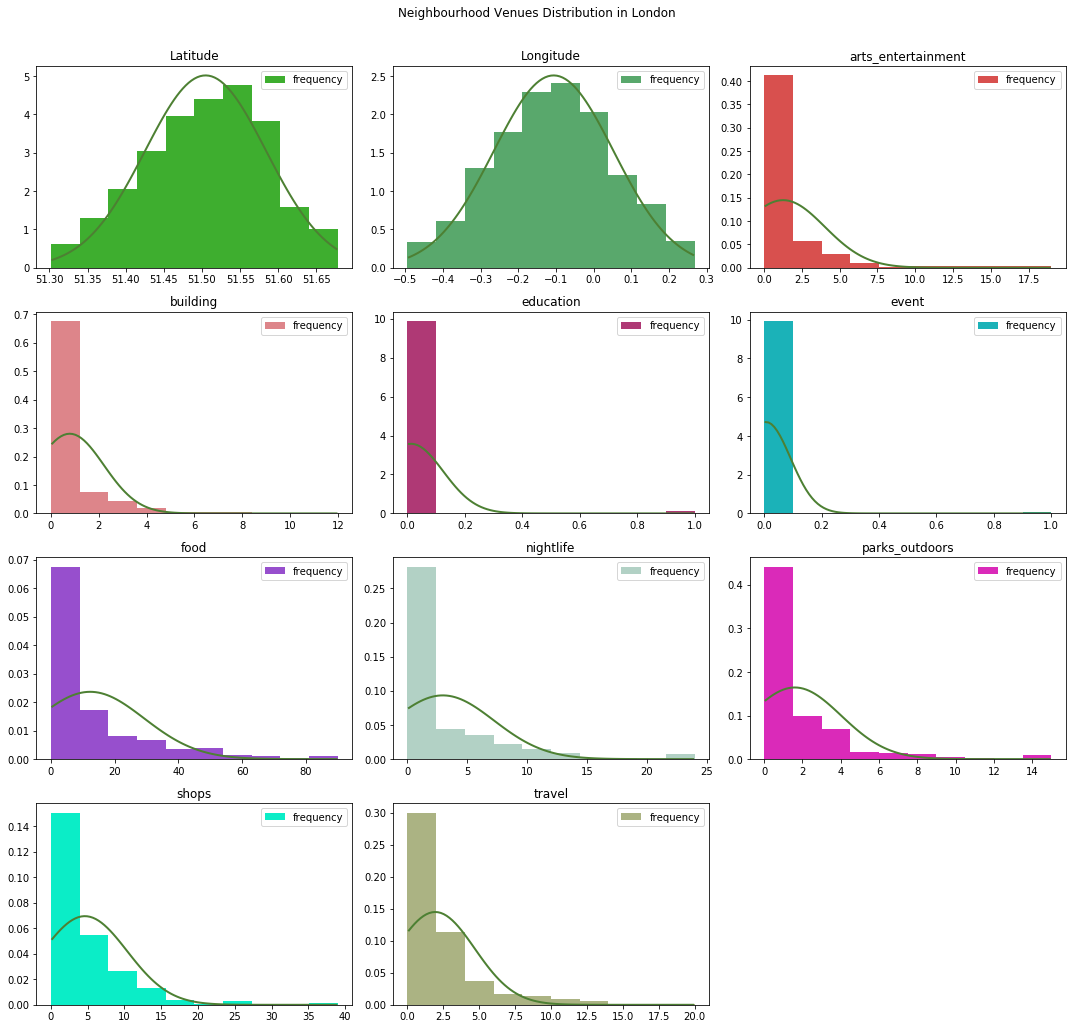

(None, None)

In [37]:
Title='Neighbourhood Venues Distribution in London'
data_features_draw_hist(neig_heat,10,11,4,3,Title)


In [38]:
address='London,UK'
zoom_start=11
prop=neig_heat
ii=0
heatmap(address,zoom_start,prop,ii)

In [39]:
address='London,UK'
zoom_start=11
prop=neig_heat
ii=1
heatmap(address,zoom_start,prop,ii)

In [40]:
address='London,UK'
zoom_start=11
prop=neig_heat
ii=2
heatmap(address,zoom_start,prop,ii)

In [41]:
address='London,UK'
zoom_start=11
prop=neig_heat
ii=3
heatmap(address,zoom_start,prop,ii)

In [42]:
address='London,UK'
zoom_start=11
prop=neig_heat
ii=4
heatmap(address,zoom_start,prop,ii)

In [43]:
address='London,UK'
zoom_start=11
prop=neig_heat
ii=5
heatmap(address,zoom_start,prop,ii)

In [44]:
address='London,UK'
zoom_start=11
prop=neig_heat
ii=6
heatmap(address,zoom_start,prop,ii)

In [45]:
address='London,UK'
zoom_start=11
prop=neig_heat
ii=7
heatmap(address,zoom_start,prop,ii)

In [46]:
address='London,UK'
zoom_start=11
prop=neig_heat
ii=8
heatmap(address,zoom_start,prop,ii)

In [47]:
address='London,UK'
zoom_start=11
prop=neig_heat
ii=9
heatmap(address,zoom_start,prop,ii)

In [48]:
address='London,UK'
zoom_start=11
prop=neig_heat
ii=10
heatmap(address,zoom_start,prop,ii)

ELBOW CURVE FOR KMEANS

In [49]:
elbow_N10=pd.read_excel('/home/sedna/Downloads/PROJECT-COURSERA-CAPSTONE/RESULTS/elbow_N10.xlsx',index_col=0)
elbow_b10=pd.read_excel('/home/sedna/Downloads/PROJECT-COURSERA-CAPSTONE/RESULTS/elbow_b10.xlsx',index_col=0)
elbow_N051=pd.read_excel('/home/sedna/Downloads/PROJECT-COURSERA-CAPSTONE/RESULTS/elbow_N051.xlsx',index_col=0)
elbow_N052=pd.read_excel('/home/sedna/Downloads/PROJECT-COURSERA-CAPSTONE/RESULTS/elbow_N052.xlsx',index_col=0)
elbow_N053=pd.read_excel('/home/sedna/Downloads/PROJECT-COURSERA-CAPSTONE/RESULTS/elbow_N053.xlsx',index_col=0)
elbow_N054=pd.read_excel('/home/sedna/Downloads/PROJECT-COURSERA-CAPSTONE/RESULTS/elbow_N054.xlsx',index_col=0)
elbow_N055=pd.read_excel('/home/sedna/Downloads/PROJECT-COURSERA-CAPSTONE/RESULTS/elbow_N055.xlsx',index_col=0)

In [50]:
elbow=[elbow_N10,elbow_b10,elbow_N051,elbow_N052,elbow_N053,elbow_N054,elbow_N055]

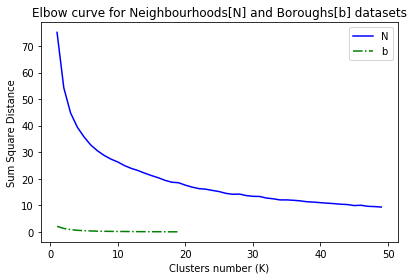

In [51]:
#code to graph a list of dictionaries
y=elbow[:2]
xlabel='Clusters number (K)'
ylabel='Sum Square Distance'
Title='Elbow curve for Neighbourhoods[N] and Boroughs[b] datasets'
mapping='equal'
grid='False'
text=''
Labels=['N','b']
boxstyle='square'
frame_from_list(y,xlabel,ylabel,Title,mapping,grid,text,Labels,boxstyle,'','')

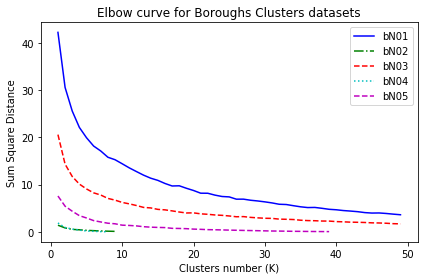

In [52]:
#code to graph a list of dictionaries
y=elbow[2:]
xlabel='Clusters number (K)'
ylabel='Sum Square Distance'
Title='Elbow curve for Boroughs Clusters datasets'
mapping='equal'
grid='False'
text=''
Labels=['bN01','bN02','bN03','bN04','bN05']
boxstyle='square'
frame_from_list(y,xlabel,ylabel,Title,mapping,grid,text,Labels,boxstyle,'','')

Centroids


In [53]:
Centroids_N10=pd.read_excel('/home/sedna/Downloads/PROJECT-COURSERA-CAPSTONE/RESULTS/Centroids_N10.xlsx',index_col=0)
Centroids_b10=pd.read_excel('/home/sedna/Downloads/PROJECT-COURSERA-CAPSTONE/RESULTS/Centroids_b10.xlsx',index_col=0)
Centroids_N05=pd.read_excel('/home/sedna/Downloads/PROJECT-COURSERA-CAPSTONE/RESULTS/Centroids_N05.xlsx',index_col=0)
Centroids_b05=pd.read_excel('/home/sedna/Downloads/PROJECT-COURSERA-CAPSTONE/RESULTS/Centroids_b05.xlsx',index_col=0)
Centroids_N051=pd.read_excel('/home/sedna/Downloads/PROJECT-COURSERA-CAPSTONE/RESULTS/Centroids_N051.xlsx',index_col=0)
Centroids_N052=pd.read_excel('/home/sedna/Downloads/PROJECT-COURSERA-CAPSTONE/RESULTS/Centroids_N052.xlsx',index_col=0)
Centroids_N053=pd.read_excel('/home/sedna/Downloads/PROJECT-COURSERA-CAPSTONE/RESULTS/Centroids_N053.xlsx',index_col=0)
Centroids_N054=pd.read_excel('/home/sedna/Downloads/PROJECT-COURSERA-CAPSTONE/RESULTS/Centroids_N054.xlsx',index_col=0)
Centroids_N055=pd.read_excel('/home/sedna/Downloads/PROJECT-COURSERA-CAPSTONE/RESULTS/Centroids_N055.xlsx',index_col=0)

In [54]:
Centroids=[Centroids_N10,Centroids_b10,Centroids_N05,Centroids_b05,Centroids_N051,Centroids_N052,Centroids_N053,Centroids_N054,Centroids_N055]

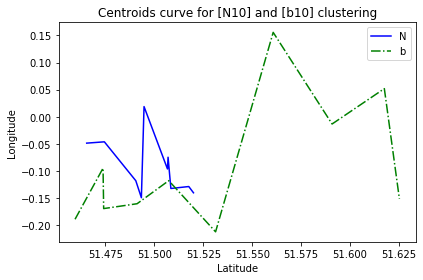

In [55]:
#code to graph a list of dataframes
y=Centroids[:2]
xlabel='Latitude'
ylabel='Longitude'
Title='Centroids curve for [N10] and [b10] clustering'
mapping='equal'
grid='False'
text=''
Labels=['N','b']
boxstyle='square'
frame_from_list(y,xlabel,ylabel,Title,mapping,grid,text,Labels,boxstyle,'','')

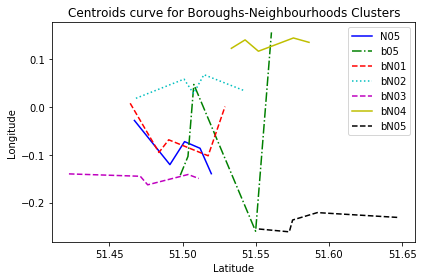

In [56]:
#code to graph a list of dataframes
y=Centroids[2:]
xlabel='Latitude'
ylabel='Longitude'
Title='Centroids curve for Boroughs-Neighbourhoods Clusters'
mapping='equal'
grid='False'
text=''
Labels=['N05','b05','bN01','bN02','bN03','bN04','bN05']
boxstyle='square'
frame_from_list(y,xlabel,ylabel,Title,mapping,grid,text,Labels,boxstyle,'','')

Kclusters

In [57]:
Kclusters_b05=pd.read_excel('/home/sedna/Downloads/PROJECT-COURSERA-CAPSTONE/RESULTS/Kclusters_b05.xlsx',index_col=0)
Kclusters_b10=pd.read_excel('/home/sedna/Downloads/PROJECT-COURSERA-CAPSTONE/RESULTS/Kclusters_b10.xlsx',index_col=0)
Kclusters_N05=pd.read_excel('/home/sedna/Downloads/PROJECT-COURSERA-CAPSTONE/RESULTS/Kclusters_N05.xlsx',index_col=0)
Kclusters_N10=pd.read_excel('/home/sedna/Downloads/PROJECT-COURSERA-CAPSTONE/RESULTS/Kclusters_N10.xlsx',index_col=0)
Kclusters_N051=pd.read_excel('/home/sedna/Downloads/PROJECT-COURSERA-CAPSTONE/RESULTS/Kclusters_N051.xlsx',index_col=0)
Kclusters_N052=pd.read_excel('/home/sedna/Downloads/PROJECT-COURSERA-CAPSTONE/RESULTS/Kclusters_N052.xlsx',index_col=0)
Kclusters_N053=pd.read_excel('/home/sedna/Downloads/PROJECT-COURSERA-CAPSTONE/RESULTS/Kclusters_N053.xlsx',index_col=0)
Kclusters_N054=pd.read_excel('/home/sedna/Downloads/PROJECT-COURSERA-CAPSTONE/RESULTS/Kclusters_N054.xlsx',index_col=0)
Kclusters_N055=pd.read_excel('/home/sedna/Downloads/PROJECT-COURSERA-CAPSTONE/RESULTS/Kclusters_N055.xlsx',index_col=0)

In [58]:
Kclusters=[Kclusters_N10,Kclusters_b10,Kclusters_N05,Kclusters_b05,Kclusters_N051,Kclusters_N052,Kclusters_N053,Kclusters_N054,Kclusters_N055]

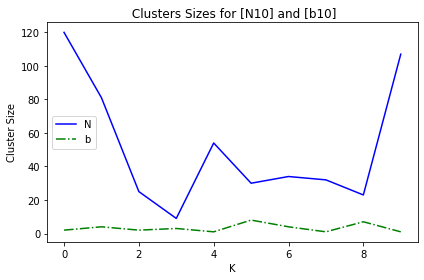

In [59]:
#code to graph a list of dataframes
y=[Kclusters[i][0:10] for i in range(2)]
xlabel='K'
ylabel='Cluster Size'
Title=' Clusters Sizes for [N10] and [b10]'
mapping='equal'
grid='False'
text=''
Labels=['N','b']
boxstyle='square'
frame_from_list(y,xlabel,ylabel,Title,mapping,grid,text,Labels,boxstyle,'','')

In [60]:
p=len(Kclusters)
range(2,p)

range(2, 9)

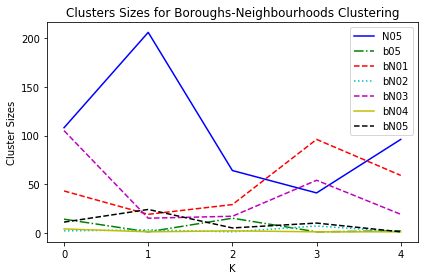

In [61]:
#code to graph a list of dataframes
y=[Kclusters[ii][0:5] for ii in range(2,p)]
xlabel='K'
ylabel='Cluster Sizes'
Title='Clusters Sizes for Boroughs-Neighbourhoods Clustering'
mapping='equal'
grid='False'
text=''
Labels=['N05','b05','bN01','bN02','bN03','bN04','bN05']
boxstyle='square'
xticks=range(5)
yticks=''
frame_from_list(y,xlabel,ylabel,Title,mapping,grid,text,Labels,boxstyle,xticks,yticks)

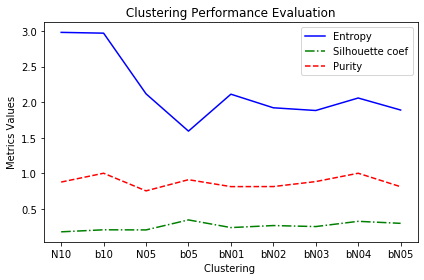

In [62]:
#code to evaluate the performance of clustering
y=Kclusters
xlabel='Clustering '
ylabel='Metrics Values'
Title=' Clustering Performance Evaluation '
mapping='equal'
grid='False'
text=''
Labels=['Entropy','Silhouette coef','Purity']
boxstyle='square'
xticks=('N10','b10','N05','b05','bN01','bN02','bN03','bN04','bN05')
yticks=''
kmeans_clustering_evaluation(y,xlabel,ylabel,Title,mapping,grid,text,Labels,boxstyle,xticks,yticks)

Identify each neighbourhood with its Cluster Labels

Finally, let's visualize the resulting clusters

address = 'London,UK'

geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

import random

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters

colors=get_colors(kclusters)

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(London_neig_merged['Latitude'], London_neig_merged['Longitude'],
                                  London_neig_merged['Neighbourhood'], London_neig_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=colors[cluster-1],
        fill=True,
        #fill_colors=colors[cluster-1],
        fill_colors='white',
        fill_opacity=0.2).add_to(map_clusters)
       
map_clusters


map_clusters.save("/home/sedna/Downloads/PROJECT-COURSERA-CAPSTONE/RESULTS/map_London_bc05_CLUSTER_05.html")

In [63]:
boroughs_grouped=pd.read_excel("/home/sedna/Downloads/PROJECT-COURSERA-CAPSTONE/RESULTS/London_boroughs_grouped.xlsx", index_col=0)

In [64]:
London_neig_grouped=pd.read_csv('/home/sedna/Downloads/PROJECT-COURSERA-CAPSTONE/DATA/london_neig_grouped_CATEGORY_mean.csv', index_col=0)